# HW4

Лучше ничего не перезапускать. Возможно, только до Data Preprocessing перезапустить стоит (если не показываются графики).

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [3]:
target = pd.read_csv('target.csv')#1
ticker = pd.read_csv('ticker.csv.gz')#2
book = pd.read_csv('book.csv.gz')#3
trades = pd.read_csv('trades.csv.gz')#4

*Threshold*

In [4]:
# Будем брать каждое 10 значение в датафрейме
book = book.iloc[::10, :]
trades = trades.iloc[::10, :]
ticker = ticker.iloc[::10, :]
target = target.iloc[::10, :]

In [5]:
book = book.reset_index(drop=True)
trades = trades.reset_index(drop=True)
ticker = ticker.reset_index(drop=True)
target = target.reset_index(drop=True)

In [6]:
threshold = '2023-03-24 23:59:59'
#threshold = '2023-03-22 23:59:59'

In [7]:
book['local_timestamp'] = pd.to_datetime(book['local_timestamp'])
trades['local_ts'] = pd.to_datetime(trades['local_ts'])
ticker['local_ts'] = pd.to_datetime(ticker['local_ts'])
target['local_ts'] = pd.to_datetime(target['local_ts'])


book = book[book['local_timestamp'] < threshold]
trades = trades[trades['local_ts'] < threshold]
ticker = ticker[ticker['local_ts'] < threshold]
target = target[target['local_ts'] < threshold]

In [8]:
#will use these slices in functions
asks_amounts = book[[f'asks[{i}].amount' for i in range(25)]]
bids_amounts = book[[f'bids[{i}].amount' for i in range(25)]]
asks_prices = book[[f'asks[{i}].price' for i in range(25)]]
bids_prices = book[[f'bids[{i}].price' for i in range(25)]]
ask_lowest_price = book[f'asks[{0}].price']
bid_highest_price = book[f'bids[{0}].price']

time = book['local_timestamp']

# Data preprocessing

In [9]:
# import hftlib
from hftlib import TechnicalFeatures as tech
from hftlib import QuantitativeFeatures as quant
from hftlib import ContMaglaras as cont

### Cont

In [10]:
L = pd.DataFrame(index = book.index)
y = target

In [11]:
#1 lob second level generation
LOBsecondRand = cont.LOBSecondLevelRand(book['asks[1].amount'], book['bids[1].amount'])
L['Ask 1 lvl random'] = LOBsecondRand['asks[1].amount']
L['Bid 1 lvl random'] = LOBsecondRand['bids[1].amount']


#2 orderflow
orderflow = cont.OrderFlow(asks_amounts, bids_amounts)
orderflowask = orderflow[0]
orderflowbid = orderflow[1]
L = pd.concat([L, orderflowask, orderflowbid], axis=1)

orderflowtotal = cont.OrderFlow(asks_amounts, bids_amounts, total=True)
L['ask orderflow'] = orderflowtotal[0]
L['bid orderflow'] = orderflowtotal[1]



#3 heavy traffic approximation
heavytraffic = cont.HeavyTrafficApproximation(asks_amounts, bids_amounts)
L['heavytraffic ask'] = heavytraffic[0]
L['heavytraffic bid'] = heavytraffic[1]



#4 arrival intervals
intervals_ask = cont.OrderIntervals(asks_amounts, time)
intervals_bid = cont.OrderIntervals(bids_amounts, time)
L['intervals_ask'] = intervals_ask
L['intervals_bid'] = intervals_bid


#5 lambdas
lambda_ask = cont.extractlambda(asks_amounts, time)
lambda_bid = cont.extractlambda(bids_amounts, time)
L['lambda_ask'] = lambda_ask
L['lambda_bid'] = lambda_bid


#6 orderflow correlation
corrof = cont.corr_OF(asks_amounts, bids_amounts)
L['corr orderflow'] = corrof


#7 spitzer tail
spitzer = cont.Spitzer_tail(asks_amounts, bids_amounts)
L['spitzer'] = spitzer


#8 probability of next price to increase
pup = cont.P_up(asks_amounts, bids_amounts, time)
L['P up'] = pup


#9 probability, if correlation of orderflow = -1
burghardt = cont.Burghardt(asks_amounts, bids_amounts, ask_lowest_price, bid_highest_price)
L['burghardt'] = burghardt


#10 volume of orders
volume_a, volume_b = cont.Volume(asks_amounts, bids_amounts)
L['volume_ask'] = volume_a
L['volume_bid'] = volume_b


#11 spread
spread = cont.Spread(asks_prices, bids_prices)
L['spread'] = spread


#12 liquidity at best price
ask, bid = cont.BestPriceLiquidity(asks_amounts, bids_amounts)
L['liquidity ask'] = ask
L['liquidity bid'] = bid


#13 LOB distribution
one, two = cont.LOBdistribution(asks_amounts, bids_amounts)
L = pd.concat([L, one, two], axis=1)

In [12]:
L.tail()

,Ask 1 lvl random,Bid 1 lvl random,ask 0 change,ask 1 change,ask 2 change,ask 3 change,ask 4 change,ask 5 change,ask 6 change,ask 7 change,...,bid share lvl 15,bid share lvl 16,bid share lvl 17,bid share lvl 18,bid share lvl 19,bid share lvl 20,bid share lvl 21,bid share lvl 22,bid share lvl 23,bid share lvl 24
640342,0.003,0.058,0.280,-0.003,-0.001,-0.017,1.119,2.613,0.089,-0.144,...,0.000339,0.000339,0.002370,0.007786,0.015234,0.055179,0.000677,0.034529,0.002708,0.007448
640343,0.003,0.060,0.500,0.000,0.000,0.000,0.000,-0.158,-0.001,0.000,...,0.000266,0.000266,0.000266,0.001332,0.011987,0.043420,0.000533,0.027171,0.002131,0.005860
640344,0.004,0.060,-2.492,0.000,-0.362,0.343,-1.099,-2.455,-0.088,1.216,...,0.000202,0.000202,0.000202,0.001009,0.000404,0.032903,0.000404,0.020589,0.001615,0.042390
640345,0.004,0.060,-0.576,0.000,0.000,-0.342,0.342,0.008,0.000,0.571,...,0.000152,0.000152,0.003504,0.000305,0.024832,0.000305,0.049817,0.001219,0.031993,0.218007
640346,0.004,0.060,-0.035,0.000,0.000,0.000,0.000,0.000,0.000,-0.394,...,0.000270,0.006218,0.000541,0.044066,0.000541,0.088402,0.002163,0.005948,0.116518,0.000270


### Tech

In [13]:
price = trades['price']
amount = trades['amount']

U = pd.DataFrame(index = price.index)

In [14]:
#1) ADL
U['ADL'] = tech.ADL(price, amount)

#2) ADX
U['ADX'] = tech.ADX(price)

#3) CMO
U['CMO'] = tech.CMO(price)

#4) Momentum
U['Momentum'] = tech.Momentum(price)

#5) ROC
U['ROC'] = tech.ROC(price)

#6) RSI
U['RSI'] = tech.RSI(price)

#7) Stochastic RSI
U['StochRSI'] = tech.StochasticRSI(price)

#8) Linear regression line
b0, b1 = tech.LinearRegressionLine(price)
U['b0 linreg'] = b0
U['b1 linreg'] = b1

#9) Realized Volatility
U['Volatlity'] = tech.RealizedVolatility(price)

#10) Realized Kernel
U['Kernel'] = tech.RealizedKernel(price)

#11) Realized Bipower Variation
U['Realized Bipower Variation'] = tech.RealizedBipowerVariation(price)

#12) Jump variation
U['Jump variation'] = tech.JumpVariation(price)

#13) Past returns
U['Past returns'] = tech.PastReturns(price)

#14) Awesome oscillator
U['Awesome oscillator'] = tech.AwesomeOscillator(price)

#15) ADXR
U['ADXR'] = tech.ADXR(price)

#16) Absolute price oscillator
U['APO'] = tech.APO(price)

#17) Average True Range
U['ATR'] = tech.ATR(price)

#18) Bollinger Bands
U['Bollinger mid'], U['Bollinger up'] ,U['Bollinger low'] = tech.Bollinger(price)

#19) ChaikinOscillator
U['CO'] = tech.ChaikinOscillator(price, amount)

#20) Chandelier Exit
U['ChandelierLong'], U['ChandelierShort'] = tech.ChandelierExit(price)

#21) Center of gravity
U['COG'] = tech.COG(price)

#22) Double exponential moving average
U['DEMA'] = tech.DEMA(price)

#23) Detrended price oscillator
U['DPO'] = tech.DPO(price)

#24) Weighted Moving Average
U['WMA'] = tech.WMA(price)

#25) Hull Moving Average
U['HMA'] = tech.HullMA(price)

#26) Internal bar strength
U['IBS'] = tech.IBS(price)

#27) Percentage price oscillator
U['PPO'] = tech.PPO(price)

#28) Autocorrelation
for i in range(1, 11):
    U[f'autocorrelation {i} lag'] = quant.Autocorrelation(price, window=100, lag=i)
    
#29)Partial Correlation
partial = quant.PartialCorrelation(price)
U = pd.concat([U, partial], axis=1)

In [15]:
U.tail()

,ADL,ADX,CMO,Momentum,ROC,RSI,StochRSI,b0 linreg,b1 linreg,Volatlity,...,PACF for lag 1,PACF for lag 2,PACF for lag 3,PACF for lag 4,PACF for lag 5,PACF for lag 6,PACF for lag 7,PACF for lag 8,PACF for lag 9,PACF for lag 10
2054886,-1187.977056,215.418699,-24.528302,0.0,-0.006559,34.302326,0.288751,7528.938633,0.725624,0.1322,...,0.983626,0.991781,0.437180,0.224171,0.354407,0.161558,0.108554,0.133791,0.068738,0.005568
2054887,-1188.104856,215.418699,-24.921136,0.0,-0.006195,34.502924,0.290048,8848.084733,0.677546,0.1321,...,0.983714,0.992232,0.436752,0.228642,0.354719,0.153147,0.106126,0.141890,0.086222,0.022335
2054888,-1188.226956,215.418699,-27.439024,-1.2,-0.010932,32.608696,0.277804,6128.687991,0.776647,0.1461,...,0.981959,0.993111,0.428079,0.211711,0.340863,0.158040,0.120490,0.136151,0.059234,-0.025800
2054889,-1188.336656,215.418699,-27.659574,-0.1,-0.011297,32.960894,0.280081,3640.913643,0.867309,0.1461,...,0.981780,0.993465,0.396960,0.185172,0.305783,0.133834,0.129044,0.149654,0.046847,-0.056069
2054890,-1188.449256,215.418699,-28.048780,0.0,-0.010932,34.302326,0.288751,3640.913643,0.867309,0.1397,...,0.982488,0.993351,0.399993,0.192472,0.311188,0.138364,0.130018,0.147345,0.044768,-0.053986


### Quant

In [16]:
V = pd.DataFrame(index = book.index)

In [17]:
#1) Order book imbalance
V['OBI'] = quant.OBI(asks_amounts, bids_amounts)

#2) Cointegration
V['Cointegration b0'], V['Cointegration b1'] = quant.Cointegration(asks_amounts, bids_amounts)

#3) Internal_imbalance_median_ask
V['Imbalance in ask'] = quant.Internal_imbalance_median_ask(asks_amounts, asks_prices)

#4) Internal_imbalance_median_bid
V['Imbalance in bid'] = quant.Internal_imbalance_median_bid(bids_amounts, bids_prices)

#5) Trade flow imbalance
V['TFI'] = quant.TFI(asks_amounts, bids_amounts)

In [18]:
V.tail()

,OBI,Cointegration b0,Cointegration b1,Imbalance in ask,Imbalance in bid,TFI
640342,-0.630126,16.019376,-0.798082,-9800.0,4.445455e+05,-10.065
640343,-0.580043,17.434824,-1.003215,-9630.0,1.240000e+06,-10.370
640344,-0.382294,17.703519,-1.074231,-9870.0,1.240000e+06,-6.132
640345,-0.252179,18.405555,-1.193341,-9870.0,1.240000e+06,-4.427
640346,-0.483019,15.520711,-0.763016,-9870.0,1.240000e+06,-6.912


#### Concating all

In [19]:
V['local_ts'] = book['timestamp']
U['local_ts'] = trades['local_ts']
L['local_ts'] = book['timestamp']

In [20]:
#if needed
U = U[U['local_ts'] > U['local_ts'].shift(1)]

In [26]:
#if needed
V = V[V['local_ts'] > V['local_ts'].shift(1)]

In [27]:
#1) Tech + Quant

V['local_ts'] = book['local_timestamp']
U['local_ts'] = trades['local_ts']

DF_lite = pd.merge_asof(left = U, right = V, direction='backward', on='local_ts')
DF_lite = pd.merge_asof(left = target, right = DF_lite, direction='backward', on='local_ts')
DF_lite.tail()

,local_ts,target,ADL,ADX,CMO,Momentum,ROC,RSI,StochRSI,b0 linreg,...,PACF for lag 7,PACF for lag 8,PACF for lag 9,PACF for lag 10,OBI,Cointegration b0,Cointegration b1,Imbalance in ask,Imbalance in bid,TFI
3756553,2023-03-24 23:59:48.128667920,0,-1188.29865,215.418699,-25.538462,0.3,-0.005831,28.977273,0.254332,-88.122569,...,0.124431,0.136041,0.057627,-0.005658,-0.027531,5.288051,0.210011,-9910.0,116582.278481,-0.375
3756554,2023-03-24 23:59:48.376390144,0,-1188.26985,215.418699,-24.375000,0.0,-0.005831,28.977273,0.254332,514.038106,...,0.096585,0.102025,0.040982,-0.018140,-0.027531,5.288051,0.210011,-9910.0,116582.278481,-0.375
3756555,2023-03-24 23:59:48.947874816,0,-1188.26985,215.418699,-24.375000,0.0,-0.005831,28.977273,0.254332,514.038106,...,0.096585,0.102025,0.040982,-0.018140,-0.027531,5.288051,0.210011,-9910.0,116582.278481,-0.375
3756556,2023-03-24 23:59:49.283046400,0,-1188.26985,215.418699,-24.375000,0.0,-0.005831,28.977273,0.254332,514.038106,...,0.096585,0.102025,0.040982,-0.018140,-0.027531,5.288051,0.210011,-9910.0,116582.278481,-0.375
3756557,2023-03-24 23:59:49.676728064,0,-1188.23115,215.418699,-24.137931,0.0,-0.005831,28.977273,0.254332,943.043463,...,0.074338,0.087160,0.022739,-0.025362,0.363497,6.808158,-0.063134,-9910.0,162413.793103,7.118


In [32]:
#if needed
L = L[L['local_ts'] > L['local_ts'].shift(1)]

In [33]:
#2) Tech + Quant + Cont

L['local_ts'] = book['local_timestamp']

DF_full = pd.merge_asof(left = DF_lite, right = L, direction='backward', on='local_ts')
DF_full.tail()

,local_ts,target,ADL,ADX,CMO,Momentum,ROC,RSI,StochRSI,b0 linreg,...,bid share lvl 15,bid share lvl 16,bid share lvl 17,bid share lvl 18,bid share lvl 19,bid share lvl 20,bid share lvl 21,bid share lvl 22,bid share lvl 23,bid share lvl 24
3756553,2023-03-24 23:59:48.128667920,0,-1188.29865,215.418699,-25.538462,0.3,-0.005831,28.977273,0.254332,-88.122569,...,0.057225,0.000151,0.000302,0.025970,0.000151,0.000151,0.018723,0.065076,0.011928,0.064170
3756554,2023-03-24 23:59:48.376390144,0,-1188.26985,215.418699,-24.375000,0.0,-0.005831,28.977273,0.254332,514.038106,...,0.067385,0.000063,0.044374,0.000063,0.000190,0.026181,0.001585,0.001141,0.065737,0.000063
3756555,2023-03-24 23:59:48.947874816,0,-1188.26985,215.418699,-24.375000,0.0,-0.005831,28.977273,0.254332,514.038106,...,0.000373,0.043530,0.024374,0.068724,0.027132,0.052177,0.000149,0.052177,0.000075,0.000224
3756556,2023-03-24 23:59:49.283046400,0,-1188.26985,215.418699,-24.375000,0.0,-0.005831,28.977273,0.254332,514.038106,...,0.000373,0.043530,0.024374,0.068724,0.027132,0.052177,0.000149,0.052177,0.000075,0.000224
3756557,2023-03-24 23:59:49.676728064,0,-1188.23115,215.418699,-24.137931,0.0,-0.005831,28.977273,0.254332,943.043463,...,0.000375,0.043745,0.024494,0.096255,0.000075,0.052434,0.000150,0.052434,0.000150,0.000225


*Создаем X и y*

In [34]:
DF_full.head()

,local_ts,target,ADL,ADX,CMO,Momentum,ROC,RSI,StochRSI,b0 linreg,...,bid share lvl 15,bid share lvl 16,bid share lvl 17,bid share lvl 18,bid share lvl 19,bid share lvl 20,bid share lvl 21,bid share lvl 22,bid share lvl 23,bid share lvl 24
0,2023-03-22 00:00:00.002269696,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-22 00:00:00.048079360,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-22 00:00:00.057478144,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-22 00:00:05.344112384,-1,NaN,NaN,NaN,-0.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-03-22 00:00:06.436654848,-1,NaN,NaN,NaN,-0.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
first_day = DF_full['local_ts'] < '2023-03-23 00:00:00'
second_and_third_days = DF_full['local_ts'] >= '2023-03-23 00:00:00'

In [79]:
X = DF_full.drop(columns = ['local_ts', 'target'])
y = DF_full['target']

X_train = X[first_day]
y_train = y[first_day]

X_test = X[second_and_third_days]
y_test = y[second_and_third_days]

### Метрика

In [37]:
from sklearn.metrics import confusion_matrix

def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
        [1.9,     0,    -2],
        [-0.3,    0,    -0.3],
        [-2,      0,     1.9]
    ])
    
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[:, 0]) + np.sum(conf_matrix[:, 2])
    if action_count == 0:
        return 0
    else:
        return hit_matrix_sum / np.sqrt(action_count)

# Model training

In [56]:
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

### Raw classifier

In [148]:
hgboost = HistGradientBoostingClassifier()

hgboost.fit(X_train, y_train)
preds = hgboost.predict(X_test)

In [149]:
raw = metric(y_test,preds)
raw

28.45532187857787

### Choosing hyperparameters

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [42]:
custom_scorer = make_scorer(metric, greater_is_better=True)

In [43]:
param_grid = {'learning_rate': [0.01,0.05,0.1],
              'max_depth': [5,6,7,8],
              'min_samples_leaf': [5,6,7]}

In [44]:
hgboost = HistGradientBoostingClassifier()

gscv = GridSearchCV(hgboost, param_grid, cv=2, scoring=custom_scorer, verbose=10)
gscv.fit(X_train,y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2; 1/36] START learning_rate=0.01, max_depth=5, min_samples_leaf=5........
[CV 1/2; 1/36] END learning_rate=0.01, max_depth=5, min_samples_leaf=5;, score=-29.305 total time=  47.0s
[CV 2/2; 1/36] START learning_rate=0.01, max_depth=5, min_samples_leaf=5........
[CV 2/2; 1/36] END learning_rate=0.01, max_depth=5, min_samples_leaf=5;, score=-162.705 total time=  45.2s
[CV 1/2; 2/36] START learning_rate=0.01, max_depth=5, min_samples_leaf=6........
[CV 1/2; 2/36] END learning_rate=0.01, max_depth=5, min_samples_leaf=6;, score=-39.332 total time=  45.8s
[CV 2/2; 2/36] START learning_rate=0.01, max_depth=5, min_samples_leaf=6........
[CV 2/2; 2/36] END learning_rate=0.01, max_depth=5, min_samples_leaf=6;, score=-168.269 total time=  44.6s
[CV 1/2; 3/36] START learning_rate=0.01, max_depth=5, min_samples_leaf=7........
[CV 1/2; 3/36] END learning_rate=0.01, max_depth=5, min_samples_leaf=7;, score=-41.149 total time=  46.1s
[C

GridSearchCV(cv=2, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 6, 7, 8],
                         'min_samples_leaf': [5, 6, 7]},
             scoring=make_scorer(metric), verbose=10)

In [45]:
gscv.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 6}

Best params {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 6}

In [150]:
hgboost = HistGradientBoostingClassifier(learning_rate=0.01, max_depth=7, min_samples_leaf=6)
hgboost.fit(X_train, y_train)

preds = hgboost.predict(X_test)

In [151]:
gridsearched = metric(y_test,preds)
gridsearched

36.084479985320634

Голый градиентный бустинг показывал скор ниже, чем бустинг после подбора гиперпараметров.

### Postprocessing

In [57]:
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train)

Learning rate set to 0.115095
0:	learn: 1.0672435	total: 1.39s	remaining: 23m 6s
1:	learn: 1.0429236	total: 2.66s	remaining: 22m 6s
2:	learn: 1.0238426	total: 3.93s	remaining: 21m 46s
3:	learn: 1.0088275	total: 5.16s	remaining: 21m 25s
4:	learn: 0.9964286	total: 6.3s	remaining: 20m 53s
5:	learn: 0.9866553	total: 7.45s	remaining: 20m 34s
6:	learn: 0.9781703	total: 8.81s	remaining: 20m 50s
7:	learn: 0.9711101	total: 9.89s	remaining: 20m 26s
8:	learn: 0.9652475	total: 11.1s	remaining: 20m 23s
9:	learn: 0.9603359	total: 12.4s	remaining: 20m 30s
10:	learn: 0.9561704	total: 13.6s	remaining: 20m 25s
11:	learn: 0.9525718	total: 14.9s	remaining: 20m 23s
12:	learn: 0.9494853	total: 15.9s	remaining: 20m 5s
13:	learn: 0.9467957	total: 16.9s	remaining: 19m 51s
14:	learn: 0.9442000	total: 17.9s	remaining: 19m 36s
15:	learn: 0.9421851	total: 18.9s	remaining: 19m 21s
16:	learn: 0.9402640	total: 20s	remaining: 19m 15s
17:	learn: 0.9385977	total: 21.1s	remaining: 19m 12s
18:	learn: 0.9369431	total: 22.1

In [58]:
colors = ['orangered']*51 + ['lightgreen']*6 + ['royalblue'] * 119

Text(0.5, 1.0, 'Feature Importance')

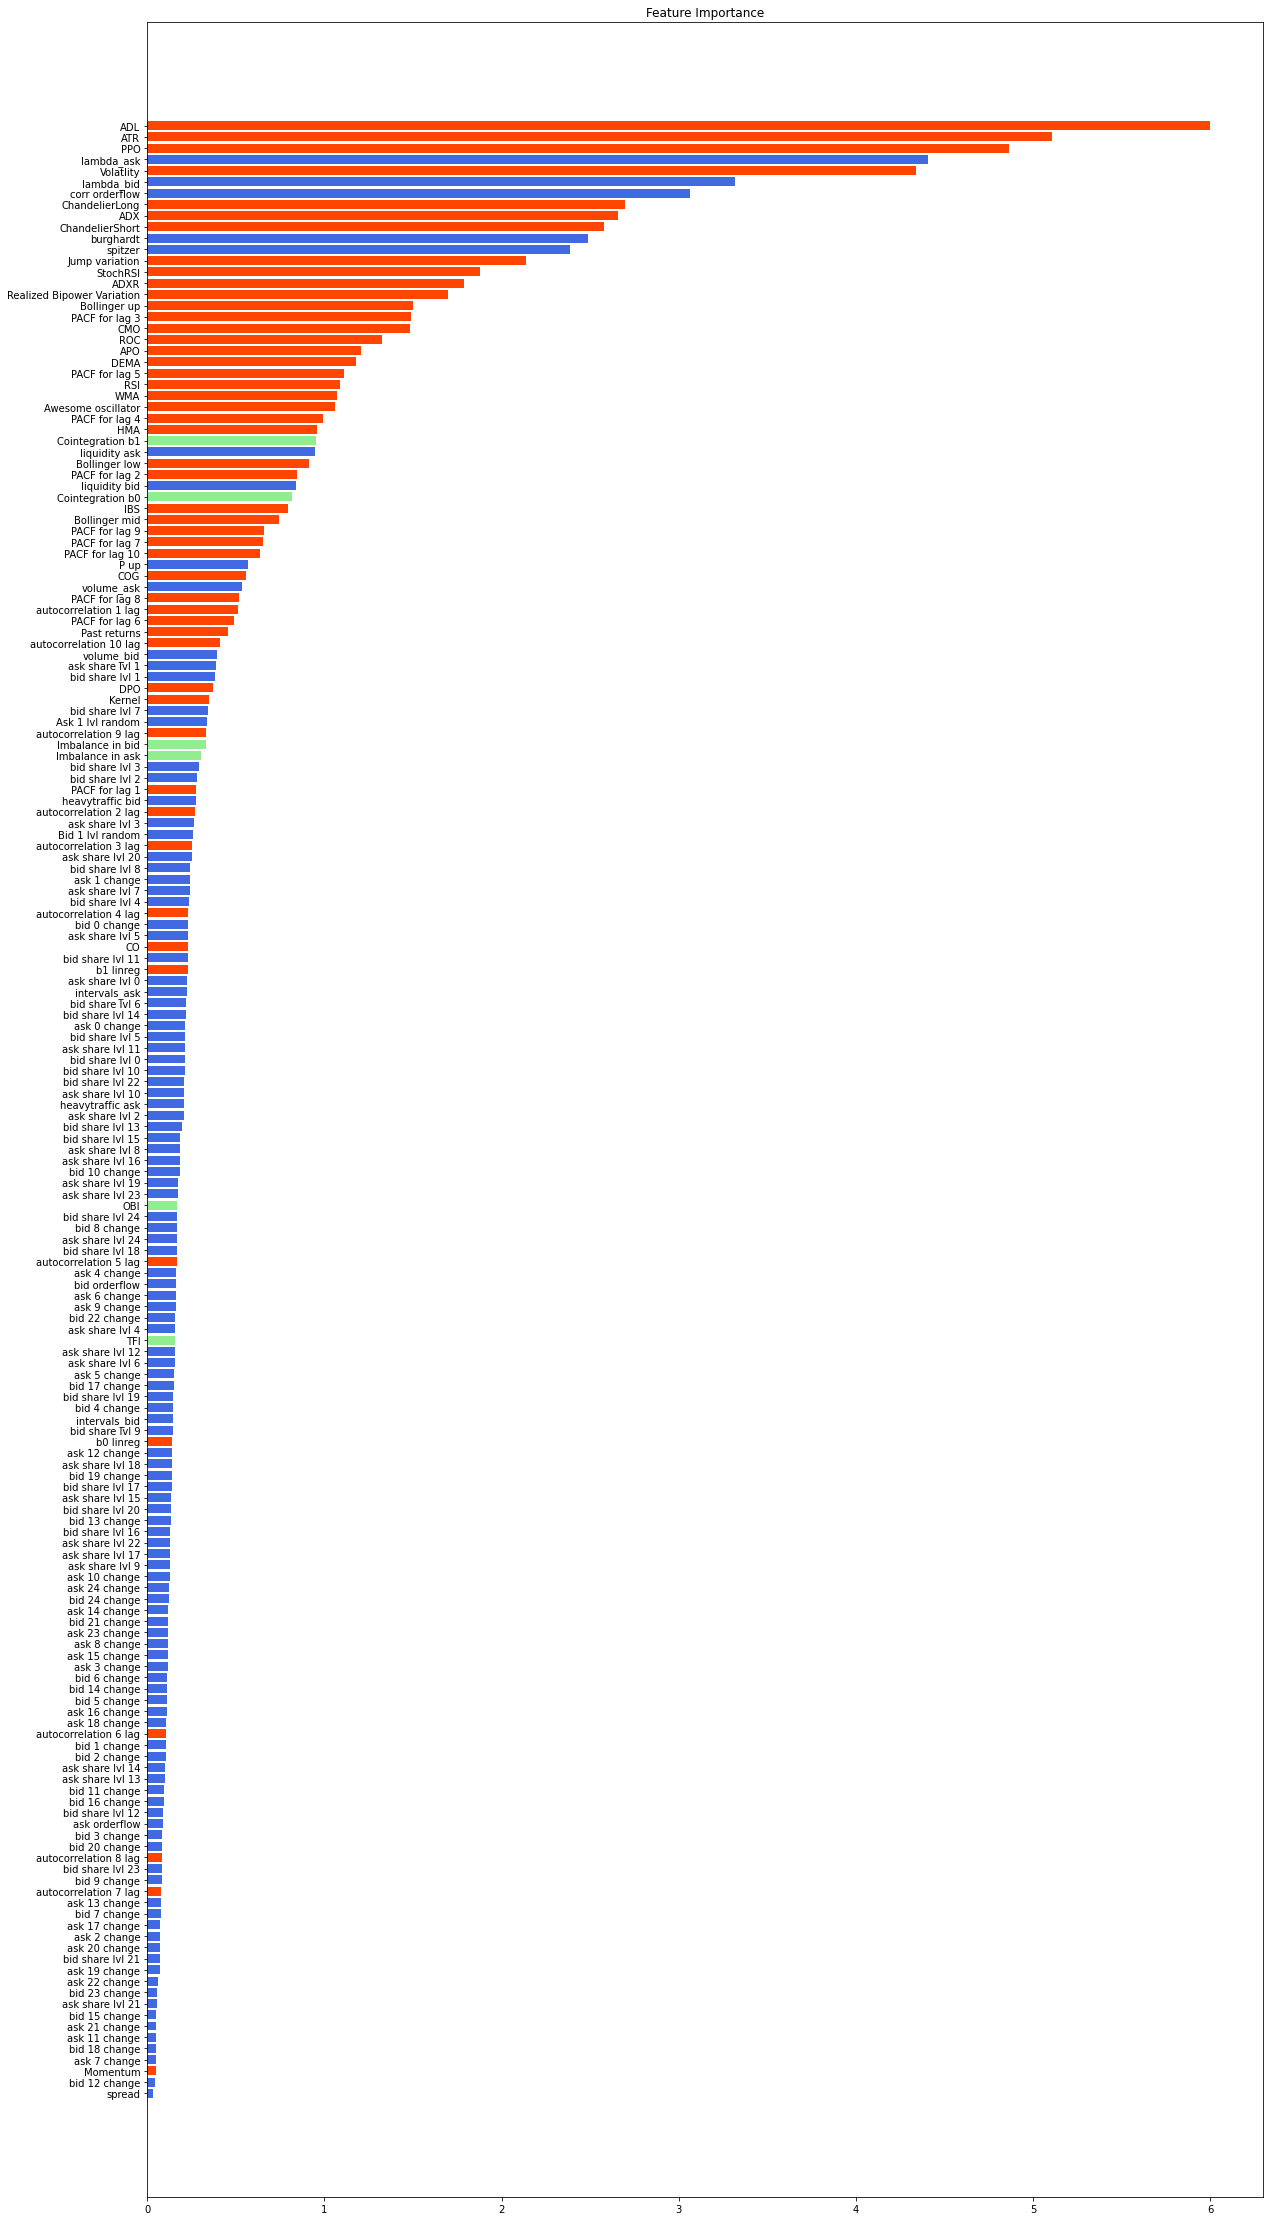

In [59]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 40))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = np.array(colors)[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Выкинем самые бесполезные фичи. Это спред, изменения на уровнях стакана, доли заявок на каждом из уровней. 

In [135]:
#columns_to_delete = [f'ask {i} change' for i in range(25)] + [f'bid {i} change' for i in range(25)]
columns_to_delete = []
columns_to_delete += [f'bid share lvl {i}' for i in range(25)] + [f'ask share lvl {i}' for i in range(25)]
columns_to_delete += ['spread', 'Momentum'] +  [f'autocorrelation {i} lag' for i in [5,6,7,8]]

In [136]:
X_reduced = X.drop(columns = columns_to_delete)



X_train_reduced = X_reduced[first_day]
X_test_reduced = X_reduced[second_and_third_days]

In [126]:
catboost = CatBoostClassifier()
catboost.fit(X_train_reduced, y_train)

Learning rate set to 0.115095
0:	learn: 1.0672112	total: 623ms	remaining: 10m 22s
1:	learn: 1.0426262	total: 1.16s	remaining: 9m 41s
2:	learn: 1.0238901	total: 1.73s	remaining: 9m 33s
3:	learn: 1.0086494	total: 2.33s	remaining: 9m 41s
4:	learn: 0.9961104	total: 2.9s	remaining: 9m 37s
5:	learn: 0.9860373	total: 3.52s	remaining: 9m 44s
6:	learn: 0.9776143	total: 4.06s	remaining: 9m 36s
7:	learn: 0.9705389	total: 4.61s	remaining: 9m 31s
8:	learn: 0.9648002	total: 5.19s	remaining: 9m 31s
9:	learn: 0.9598111	total: 5.72s	remaining: 9m 26s
10:	learn: 0.9555125	total: 6.17s	remaining: 9m 15s
11:	learn: 0.9516449	total: 6.69s	remaining: 9m 11s
12:	learn: 0.9484982	total: 7.16s	remaining: 9m 3s
13:	learn: 0.9457344	total: 7.62s	remaining: 8m 56s
14:	learn: 0.9431946	total: 8.08s	remaining: 8m 50s
15:	learn: 0.9408485	total: 8.64s	remaining: 8m 51s
16:	learn: 0.9388993	total: 9.16s	remaining: 8m 49s
17:	learn: 0.9372533	total: 9.62s	remaining: 8m 44s
18:	learn: 0.9356970	total: 10.1s	remaining: 

Text(0.5, 1.0, 'Feature Importance')

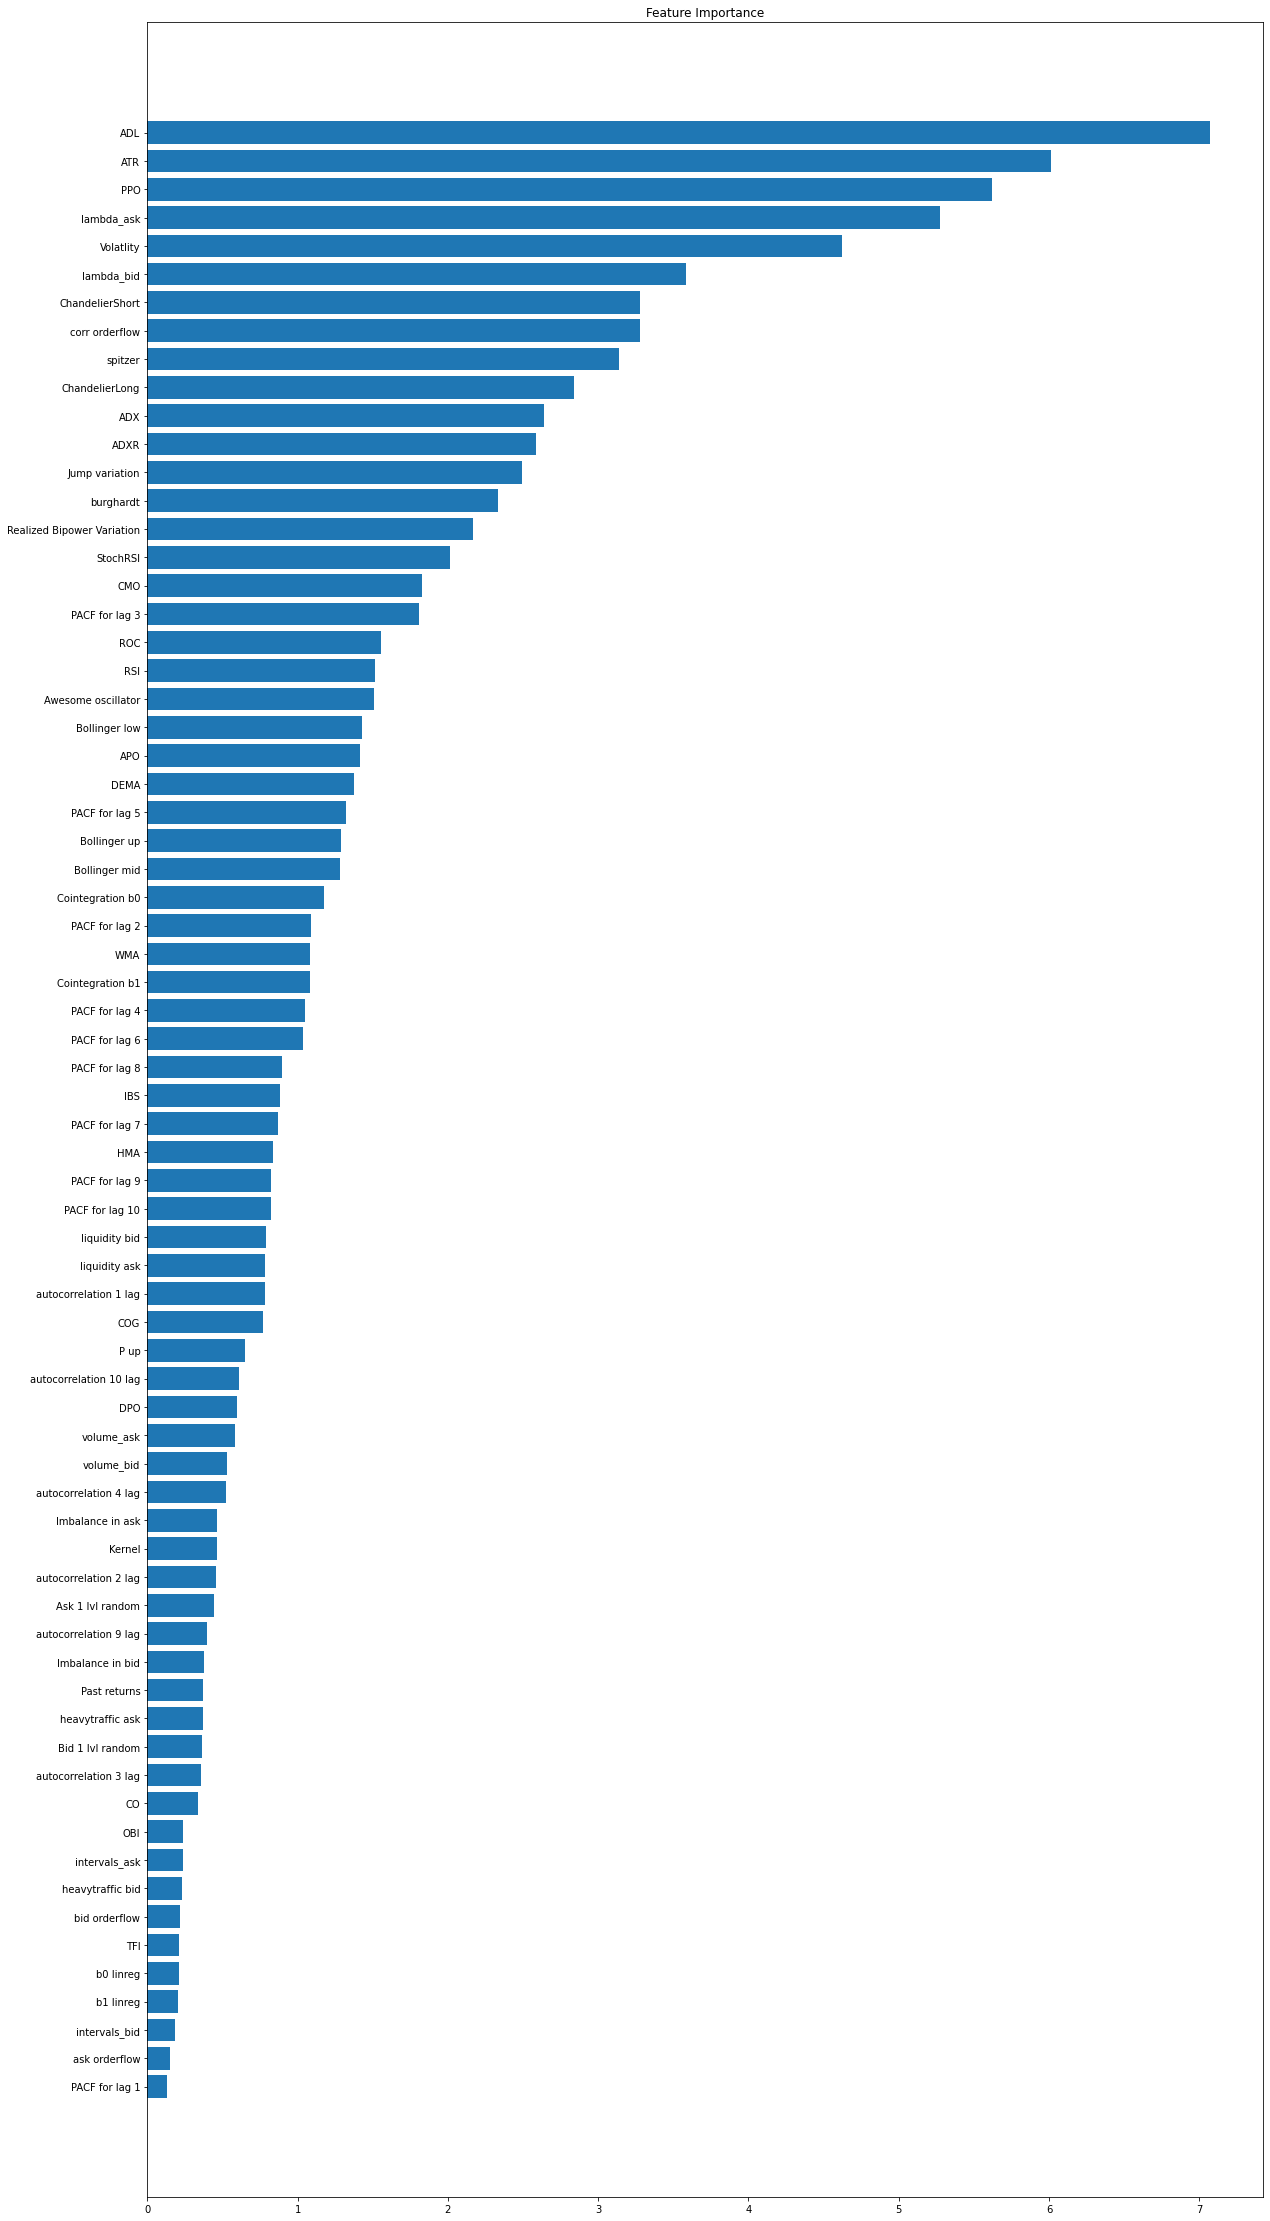

In [128]:
feature_importance = catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 40))

plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_reduced.columns)[sorted_idx])
plt.title('Feature Importance')

Замеряем качество

In [154]:
hgboost = HistGradientBoostingClassifier()
hgboost.fit(X_train_reduced, y_train)

preds = hgboost.predict(X_test_reduced)

In [155]:
post_processed = metric(y_test,preds)
post_processed

43.951008698336366

Скор вырос еще.

In [161]:
scores_table = pd.DataFrame(columns = ['raw boosting', 'after gridsearch', 'after postprocessing'],
                            data = [[raw, gridsearched, post_processed]], index = ['score'])

scores_table

,raw boosting,after gridsearch,after postprocessing
score,28.455322,36.08448,43.951009


### Custom loss function (Она не получилась)

In [71]:
class UserDefinedMetric(object):
    def is_max_optimal(self):
        # Returns whether great values of metric are better
        return True
        

    def evaluate(self, approxes, target, weight=1):
        # approxes is a list of indexed containers
        # (containers with only __len__ and __getitem__ defined),
        # one container per approx dimension.
        # Each container contains floats.
        # weight is a one dimensional indexed container.
        # target is a one dimensional indexed container.

        # weight parameter can be None.
        # Returns pair (error, weights sum)
        
        preds = np.array(approxes).argmax(axis=1)
        
        rev = 0
        count = 0
        for i in range(len(preds)):
            if target[i] == 0:
                if preds[i] != 0:
                    rev -= 0.3
            elif target[i] == 1:
                if preds[i] == 1:
                    rev += 1.9
                elif preds[i] == 2:
                    rev -= 2
            else:
                if preds[i] == 2:
                    rev += 1.9
                elif preds[i] == 1:
                    rev -= 2
                    
            if preds[i] != 0:
                count+=1
        return rev/np.sqrt(count), count
                
            
            
        preds = np.array(approxes).argmax(axis=1)
        return metric(target, preds), len(target)*weight
        

    def get_final_error(self, error, weight=1):
        # Returns final value of metric based on error and weight
        
        return error / (weight + 1e-10)

In [72]:
class My_Loss(object):
    def calc_ders_multi(self, approx, target, weight=1):
        # approxes - indexed container of floats with predictions
        #            for each dimension of single object
        # target - contains a single expected value
        # weight - contains weight of the object
        #
        # This function should return a tuple (-der1, -der2), where
        # - der1 is a list-like object of first derivatives of the loss function with respect
        # to the predicted value for each dimension.
        # - der2 is a matrix of second derivatives.
        hess = [[0 for i in range(3)] for j in range(3)]

        minusone = (target==-1)*1.9 + (target==0)*-0.3 + (target == 1)*-2
        plusone = (target==1)*1.9 + (target==0)*-0.3 + (target == -1)*-2
        zero = 0

        grad = [-zero, -plusone, -minusone]

        return (grad, hess)

In [70]:
y_train[y_train==-1] = 2
y_train[y_train==2]

1         2
2         2
3         2
4         2
5         2
         ..
155171    2
155172    2
155175    2
155181    2
155182    2
Name: target, Length: 43132, dtype: int64

In [73]:
catboost = CatBoostClassifier(classes_count=3, loss_function=My_Loss(), eval_metric=UserDefinedMetric())
catboost.fit(X_train, y_train)

0:	learn: 0.0000000	total: 1.39s	remaining: 23m 5s
1:	learn: 0.0000000	total: 2.52s	remaining: 20m 55s
2:	learn: 0.0000000	total: 3.63s	remaining: 20m 7s
3:	learn: 0.0000000	total: 4.73s	remaining: 19m 37s
4:	learn: 0.0000000	total: 5.86s	remaining: 19m 25s
5:	learn: 0.0000000	total: 6.98s	remaining: 19m 16s
6:	learn: 0.0000000	total: 8.09s	remaining: 19m 8s
7:	learn: 0.0000000	total: 9.24s	remaining: 19m 5s
8:	learn: 0.0000000	total: 10.3s	remaining: 18m 57s
9:	learn: 0.0000000	total: 11.4s	remaining: 18m 53s
10:	learn: 0.0000000	total: 12.6s	remaining: 18m 48s
11:	learn: 0.0000000	total: 13.7s	remaining: 18m 45s
12:	learn: 0.0000000	total: 14.8s	remaining: 18m 41s
13:	learn: 0.0000000	total: 15.9s	remaining: 18m 37s
14:	learn: 0.0000000	total: 17s	remaining: 18m 33s
15:	learn: 0.0000000	total: 18.1s	remaining: 18m 30s
16:	learn: 0.0000000	total: 19.2s	remaining: 18m 30s
17:	learn: 0.0000000	total: 20.4s	remaining: 18m 30s
18:	learn: 0.0000000	total: 21.5s	remaining: 18m 31s
19:	learn

KeyboardInterrupt: 